<h2>Coleta de dados - Mestrado</h2>

Esse código é responsável por coletar ligantes de um determinado alvo a partir do API do ChEMBL.

Começamos importando as bibliotecas:

In [3]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
#from tqdm.auto import tqdm

Na sequência, setamos o caminho para salvar os arquivos

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

#checamos a versão do python utilizada para rodar os códigos
from platform import python_version
python_version()

'3.10.4'

In [5]:
#Criando os resource objects para o acesso ao API
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [6]:
type(targets_api)
uniprot_id = "P13922"

Primeiro, pegamos a <b>UniProt ID</b> do alvo de interesse, nesse caso vamos começar utilizando a DHFR-TS que é a "P13922"
Coletamos numa variável (uniprot_id) e coletamos os alvos na variável "targets"

In [7]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'O tipo do alvo é "{type(targets)}"') #essa resposta devera ser chembl_webresource_client.query_set.QuerySet

O tipo do alvo é "<class 'chembl_webresource_client.query_set.QuerySet'>"


Os resultados do <i>query</i> ficam armazenados na variavel "targets" e os resultados não são reconhecidos até usarmos o pandas para buscá-los.

In [8]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Plasmodium falciparum K1,Dihydrofolate reductase,CHEMBL1939,SINGLE PROTEIN
1,Plasmodium falciparum K1,Dihydrofolate reductase,CHEMBL1939,SINGLE PROTEIN


Selecionamos apenas a primeira linha da tabela acima. Na verdade, nesse caso tanto faz pois o target_chembl_id é o mesmo para ambas as linhas.

In [9]:
target = targets.iloc[1]

In [10]:
chembl_id = target.target_chembl_id #retiramos o chembl_id para filtrarmos as moleculas e atividades biologicas relacionadas
print(f"O alvo ChEMBL ID é {chembl_id}") 
# checamos o ID do alvo no ChEMBL

O alvo ChEMBL ID é CHEMBL1939


---
<h3>Baixando as atividades biológicas:</h3>

Em sequência, baixamos as atividades biológicas e filtramos apenas os valores de Ki presentes;

In [11]:
bioactivities = bioactivities_api.filter(target_chembl_id=chembl_id, type="Ki", relation="=", assay_type="B").only(
    "activity_id", #o tipo de atividade
    "assay_chembl_id",#o numero do ensaio relacionado
    "assay_description",#descricao do ensaio relacionado
    "assay_type", #tipo de ensaio
    "molecule_chembl_id", #id da molecula
    "type", #tipo
    "standard_units", #unidades
    "relation", #relacao
    "standard_value",#valor padronizado
    "target_chembl_id", #id chembl do alvo
    "target_organism", #organismo alvo
)
print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 716, <class 'chembl_webresource_client.query_set.QuerySet'>


Como o objeto é uma lista encadeada, selecionamos, por fim apenas o dataframe contido no primeiro elemento.

In [12]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0] #como o objeto é uma lista encadeada, selecionamos apenas o dataframe contido no primeiro elemento
;

Length and type of first element: 13, <class 'dict'>


''

<h3>Transformação em dataframe:</h3>

Para trabalharmos da melhor maneira possível com os dados, assim como no R, transformamos a lista encadeada em um dataframe usando a funcao <b>pd.Dataframe.from_records</b>

In [13]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (717, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
1,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
2,185072,CHEMBL811759,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,14.5,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,14.5
3,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,3.1
4,187527,CHEMBL668412,Inhibitory activity against double mutant dihy...,B,CHEMBL324775,=,nM,103.5,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,103.5


Verificamos o tipo de cada variavel e transformamos os valores de atividade biologica em "float" para evitarmos que seja truncado ou arredondado e comprometa de alguma forma a nossa análise

In [14]:
#como parte de boas praticas, verificamos o tipo de cada variavel e transformamos a variavel em float para que não seja truncado ou arredondado
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})

bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
units                  object
value                  object
dtype: object

Também como forma de boas práticas de modelagem, retiramos todos os valores tidos como "NA" no banco de moléculas, uma vez que isso inviabilizará a obtenção de dados e/ou modelos mais pra frente. Nesse caso em específico, vemos que não há nenhuma variável com dados faltantes.

In [15]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (717, 13)


É importante conferir se existe alguma outra unidade de medida presente no banco de dados obtido. Nesse caso não observamos nenhum outro tipo de unidade de medida biologica a nao ser nM.

In [16]:
print(f"Tipos de unidades nos dados baixados: {bioactivities_df['standard_units'].unique()}")

print(    f"Numero de dados sem valores na faixa do nanomolar nM:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}")

Tipos de unidades nos dados baixados: ['nM']
Numero de dados sem valores na faixa do nanomolar nM:    0


Observamos que não há nenhuma atividade biológica medida de outra forma que não o nanomolar. Mesmo que nesse caso não se aplique, é importante sempre filtrar o banco de dados para uma mesma unidade de medida.

In [17]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")
print(f"DataFrame shape: {bioactivities_df.shape}")

Units after filtering: ['nM']
DataFrame shape: (717, 13)


---
<h3>Removendo estruturas redundantes</h3>

Agora chegamos em um ponto bastante crucial para o desenvolvimento dos modelos: a quantidade de moléculas. É fato que temos 717 medições experimentais, mas na verdade temos a mesma quantidade de moléculas? Ou foram realizados várias medições biológicas para um número menor de estruturas. A resposta se dá abaixo com o "drop_duplicates". Mantemos as que aparecem primeiro

In [18]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (145, 13)


Pois é, vemos que na verdade das mais de 700 atividades biológicas medidas, possuimos apenas 145 estruturas diferentes. A ideia agora é juntar as estruturas para a espécie <i>falciparum</i> e <i>vivax</i>! (Acho que para outra espécie temos cerca de ~30 estruturas)

Função muito massa para mostrar o dataframe por completo (by: Artur & Victor)

In [19]:
def df_inteiro(df):
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(df)

In [20]:
bioactivities_df.reset_index(drop=True, inplace=True) #nós resetamos os índices do dataframe
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,3.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,0.4
3,189896,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL291931,=,nM,7.2,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,7.2
4,189912,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL119188,=,nM,0.6,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,0.6


In [21]:
df_inteiro(bioactivities_df) #IMPORTANTE (mostrando o dataframe por completo, caso precise acessá-lo do jupyter notebook)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.70,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.10,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,3.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.40,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,0.4
3,189896,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL291931,=,nM,7.20,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,7.2
4,189912,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL119188,=,nM,0.60,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,0.6
5,190145,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL747,=,nM,2.60,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,2.6
6,191425,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL29773,=,nM,1.07,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,1.07
7,192296,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL30937,=,nM,17.80,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,17.8
8,193460,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL22138,=,nM,1.70,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,1.7
9,193476,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL56146,=,nM,6.50,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,6.5


Em sequência, renomeamos as colunas standard value e standard units para "Ki" e "units"

In [22]:
bioactivities_df.rename(
columns={"standard_value":"Ki"}, inplace = True
)

bioactivities_df = bioactivities_df[bioactivities_df.columns[0:11]]


In [23]:
print(f"formato do dataframe: {bioactivities_df.shape}")
bioactivities_df.head()

formato do dataframe: (145, 11)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,Ki,target_chembl_id,target_organism,type
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki
3,189896,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL291931,=,nM,7.2,CHEMBL1939,Plasmodium falciparum K1,Ki
4,189912,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL119188,=,nM,0.6,CHEMBL1939,Plasmodium falciparum K1,Ki


---
<h2>Download das estruturas em SMILES do ChEMBL</h2>
Chegamos em uma etapa muito importante para buscarmos as estruturas em SMILES.

In [24]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [25]:
compounds = list((compounds_provider))

In [26]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (145, 2)


In [27]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL7004,{'canonical_smiles': 'Cc1ccc(N2C(N)=NC(N)=NC2(...
1,CHEMBL7005,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
2,CHEMBL6741,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
3,CHEMBL6742,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
4,CHEMBL22,{'canonical_smiles': 'COc1cc(Cc2cnc(N)nc2N)cc(...


Agora processaremos os dados da estrutura. Chegou a hora da curadoria das moléculas.
1. Remover as linhas sem estruturas (acredito que nenhuma)
2. Deletar moléculas duplicadas
3. Conferir as moléculas com SMILES canônicos (com check de sanidade)


In [28]:
#1
compounds_df.dropna(axis = 0, how = "any", inplace = True)
print(f"DataFrame shape: {compounds_df.shape}")

#vemos que não há nenhuma linha no dataframe sem SMILES ou ID. Ótimo!

DataFrame shape: (145, 2)


In [29]:
#2
compounds_df.drop_duplicates("molecule_chembl_id", keep = "first", inplace = True)
print(f"DataFrame shape: {compounds_df.shape}")

#vemos que não há moléculas duplicadas no nosso dataframe final

DataFrame shape: (145, 2)


Na sequência, pegamos todas as moléculas com canonical SMILES, mantendo apenas esse formato

In [30]:
compounds_df.iloc[0].molecule_structures.keys()
#observamos que há canonical smiles, molfile, inchi e inchi key;

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [31]:
#Nós queremos manter apenas os SMILES canônicos
canonical_smiles = [] #lista vazia

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"]
                               )
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis = 1, inplace = True)
print(f"Formato do dataframe: {compounds_df.shape}")

Formato do dataframe: (145, 2)


Fazemos o check de sanidade

In [32]:
compounds_df.dropna(axis = 0, how = "any", inplace = True)
print(f'Formato do dataframe: {compounds_df.shape}')
#na verdade nenhuma molecula sem o seu respectivo canonical smile

Formato do dataframe: (145, 2)


<h2>Juntando ambos os dataframes</h2>

Iremos juntar ambos os dataframes (compounds) e atividades:

In [33]:
#juntando ambos os dataframes

output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "Ki", "standard_units"]],
    compounds_df,
    on = "molecule_chembl_id"
)

output_df.reset_index(drop = True, inplace = True)
print(f'Dataset contendo {output_df.shape} linhas, colunas')

Dataset contendo (145, 4) linhas, colunas


In [34]:
output_df.dtypes

molecule_chembl_id     object
Ki                    float64
standard_units         object
smiles                 object
dtype: object

In [35]:
output_df.head(10)

,molecule_chembl_id,Ki,standard_units,smiles
0,CHEMBL2364573,4.70,nM,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...
1,CHEMBL324775,3.10,nM,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC
2,CHEMBL416373,0.40,nM,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...
3,CHEMBL291931,7.20,nM,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1
4,CHEMBL119188,0.60,nM,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1
5,CHEMBL747,2.60,nM,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1
6,CHEMBL29773,1.07,nM,CCc1nc(N)nc(N)c1-c1cccc(OC)c1
7,CHEMBL30937,17.80,nM,CCCCCCCOc1ccc(Cc2cnc(N)nc2N)cc1
8,CHEMBL22138,1.70,nM,Nc1ncc(Cc2ccc(OCc3ccccc3)c(OCc3ccccc3)c2)c(N)n1
9,CHEMBL56146,6.50,nM,Nc1ncc(Cc2ccc(OCc3ccccc3)cc2)c(N)n1


In [36]:
def convert_ki_to_pki(Ki):
    pKi = 9 - math.log10(Ki)
    return pKi

In [37]:
output_df["pKi"]= output_df.apply(lambda x: convert_ki_to_pki(x.Ki), axis =1)

In [38]:
output_df.head()

,molecule_chembl_id,Ki,standard_units,smiles,pKi
0,CHEMBL2364573,4.7,nM,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.327902
1,CHEMBL324775,3.1,nM,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,8.508638
2,CHEMBL416373,0.4,nM,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,9.397940
3,CHEMBL291931,7.2,nM,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,8.142668
4,CHEMBL119188,0.6,nM,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,9.221849


---
<h2>Análise inicial dos dados!</h2>
neste momento realizamos uma pequena análise inicial dos dados

array([[<AxesSubplot:title={'center':'pKi'}>]], dtype=object)

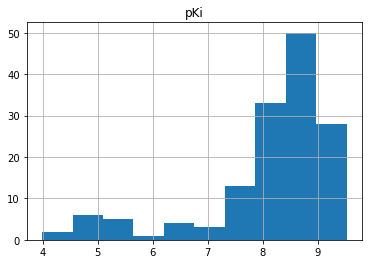

In [39]:
output_df.hist(column="pKi")

In [40]:
#adicionando as moleculas em mol

PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [41]:
output_df.sort_values(by = "pKi", ascending = False, inplace = True)

#resetando o indice
output_df.reset_index(drop = True, inplace = True)

,molecule_chembl_id,Ki,standard_units,pKi,ROMol
0,CHEMBL22405,0.3,nM,9.522879,
1,CHEMBL278847,0.3,nM,9.522879,
2,CHEMBL282275,0.3,nM,9.522879,

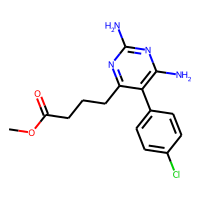
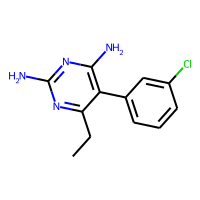
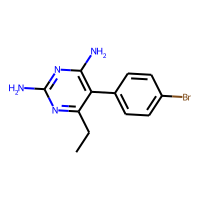

In [42]:
output_df.drop("smiles", axis=1).head(3)


In [43]:
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (145, 5)


In [44]:
output_df.head()

,molecule_chembl_id,Ki,standard_units,smiles,pKi
0,CHEMBL22405,0.3,nM,COC(=O)CCCc1nc(N)nc(N)c1-c1ccc(Cl)cc1,9.522879
1,CHEMBL278847,0.3,nM,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,9.522879
2,CHEMBL282275,0.3,nM,CCc1nc(N)nc(N)c1-c1ccc(Br)cc1,9.522879
3,CHEMBL416552,0.3,nM,CCCCCCc1nc(N)nc(N)c1-c1ccccc1,9.522879
4,CHEMBL22901,0.3,nM,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(OC)c1,9.522879


<h3>Salvando os dados em csv:</h3>

In [52]:
output_df.to_csv(DATA/"DHFR_compounds_chembl.csv")